# Clustering of Countries 

1. Data Understanding and Cleaning
2. Data Preparation
3. Modelling

In [90]:
#import all the necessary libraries

import pandas as pd
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# Data Understanding

In [91]:
#let's read the dataset
dat = pd.read_csv('Country-data.csv')
dat.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Let's convert imports,exports and health spending from  percentage values to actual values of their GDP per capita
.Because the percentage values don't give a clear picture of that country. 
For ex. afghanistan and albania have similar imports percentange but their gdpp has a huge gap which doesn't give an accurate idea of which country is more developed than the other.

In [ ]:
#Converting exports,imports and health spending percentages to absolute values.
dat['exports'] = dat['exports']*dat['gdpp']/100
dat['imports'] = dat['imports']*dat['gdpp']/100
dat['health'] = dat['health']*dat['gdpp']/100

In [93]:
dat.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [94]:
dat.shape

(167, 10)

In [95]:
#basic data checks
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


In [96]:
#basic data cleaning checks
dat.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

# Data Preparation

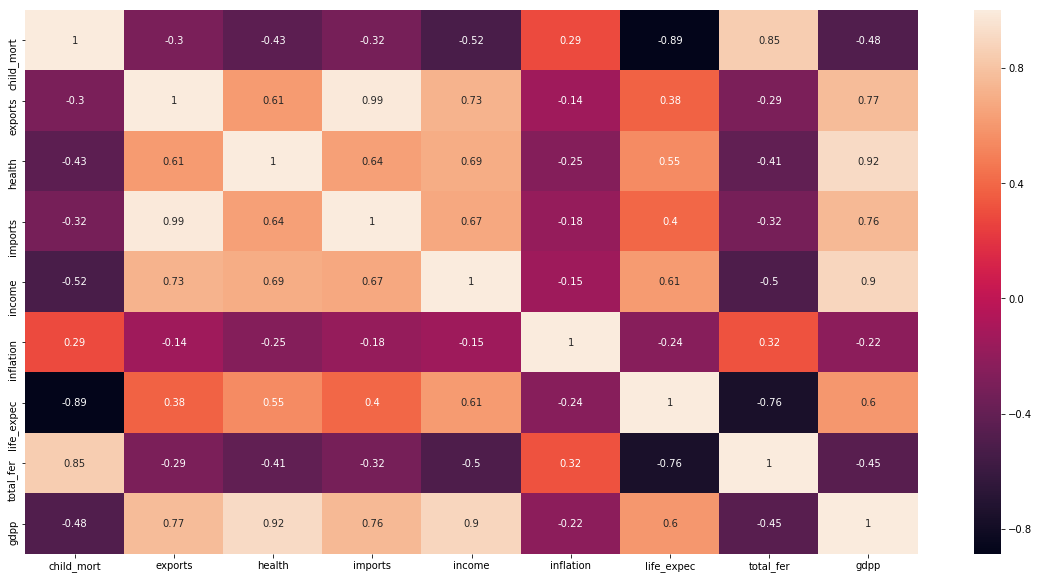

In [117]:
#so this data seems largely clean,but we have a lot of variables and making and visualising proper clusters will be a difficulty.
#Let's see if we can apply PCA to do dimensional reduction
#first let's plot the correlation matrix and check if the data is indeed highly correlated
#so that the usage of PCA in this scenario is justified
plt.figure(figsize = (20,10))        
sns.heatmap(dat.corr(),annot = True)

A lot of highly correlated variables exist, hence the usage of PCA is justified. 
Now let's proceed to doing it on the dataset

In [118]:
#The final matrix would only contain the data columns. Hence let's drop the country column
datm=dat.drop(['country'],axis=1)
datm.head()  

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [119]:
#we observe that a lot of the data variables are of different orders of magnitude. 
#Let's do rescaling so that PCA can be applied.
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
dat2 = standard_scaler.fit_transform(datm)

In [120]:
dat2

array([[ 1.29153238, -0.4110113 , -0.56503989, ..., -1.61909203,
         1.90288227, -0.67917961],
       [-0.5389489 , -0.35019096, -0.43921769, ...,  0.64786643,
        -0.85997281, -0.48562324],
       [-0.27283273, -0.31852577, -0.48482608, ...,  0.67042323,
        -0.0384044 , -0.46537561],
       ...,
       [-0.37231541, -0.36146329, -0.53848844, ...,  0.28695762,
        -0.66120626, -0.63775406],
       [ 0.44841668, -0.39216643, -0.55059641, ..., -0.34463279,
         1.14094382, -0.63775406],
       [ 1.11495062, -0.38395214, -0.54049845, ..., -2.09278484,
         1.6246091 , -0.62954556]])

In [121]:
#Importing the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [122]:
#let's apply PCA
pca.fit(dat2)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [123]:
#List of PCA components.It would be the same as the number of variables
pca.components_

array([[-0.31639186,  0.34288671,  0.358535  ,  0.34486492,  0.38004113,
        -0.14308531,  0.34385651, -0.30284224,  0.39998795],
       [ 0.47626735,  0.39731091,  0.1550529 ,  0.37078075,  0.12838448,
         0.22126089, -0.36981973,  0.4597152 ,  0.2006241 ],
       [-0.15001225, -0.03057367, -0.07570322, -0.07217386,  0.14576421,
         0.94841868,  0.19675173, -0.07783431,  0.01033941],
       [-0.14805195,  0.44942527, -0.59971228,  0.46179779, -0.15480592,
        -0.00762798, -0.01839465, -0.21392805, -0.36477239],
       [ 0.1019948 , -0.03853829, -0.49319984, -0.2527867 ,  0.79407469,
        -0.13642345, -0.15404105, -0.02033568,  0.08750149],
       [ 0.19658519, -0.03891112,  0.18069888, -0.01217988, -0.03814681,
         0.10840284, -0.58600986, -0.75390075,  0.04538167],
       [ 0.76126725, -0.01366973, -0.06461567,  0.02718244, -0.02311312,
        -0.02207663,  0.58120846, -0.27314534, -0.04402264],
       [ 0.00644411, -0.05526371,  0.43007213,  0.1311355 ,  0

In [124]:
#Let's check the variance ratios
pca.explained_variance_ratio_

array([5.89372984e-01, 1.84451685e-01, 9.91147170e-02, 6.07227801e-02,
       3.02917253e-02, 2.45982702e-02, 9.39743701e-03, 1.55641971e-03,
       4.93981394e-04])

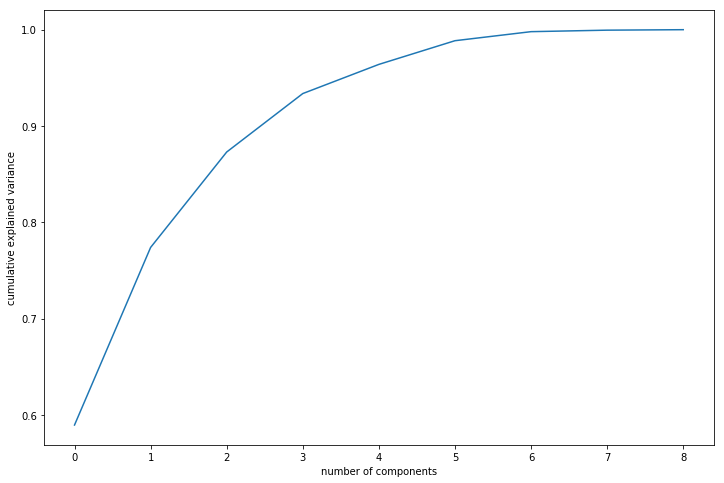

In [126]:
#Plotting the scree plot
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Clearly over 90% of the data is properly explained by the first 3 principal components. Let's use them only for our clustering process

In [127]:
#Let's try and check the first three components now
colnames = list(dat.drop('country',axis=1).columns)
pcs_df = pd.DataFrame({ 'Feature':colnames,'PC1':pca.components_[0],'PC2':pca.components_[1],'PC3':pca.components_[2]})
pcs_df

,Feature,PC1,PC2,PC3
0,child_mort,-0.316392,0.476267,-0.150012
1,exports,0.342887,0.397311,-0.030574
2,health,0.358535,0.155053,-0.075703
3,imports,0.344865,0.370781,-0.072174
4,income,0.380041,0.128384,0.145764
5,inflation,-0.143085,0.221261,0.948419
6,life_expec,0.343857,-0.369820,0.196752
7,total_fer,-0.302842,0.459715,-0.077834
8,gdpp,0.399988,0.200624,0.010339


Let's plot them to get a better idea about which variables are well explained by these 3 components. We'll use only the first 2 PCs here and check their variance.

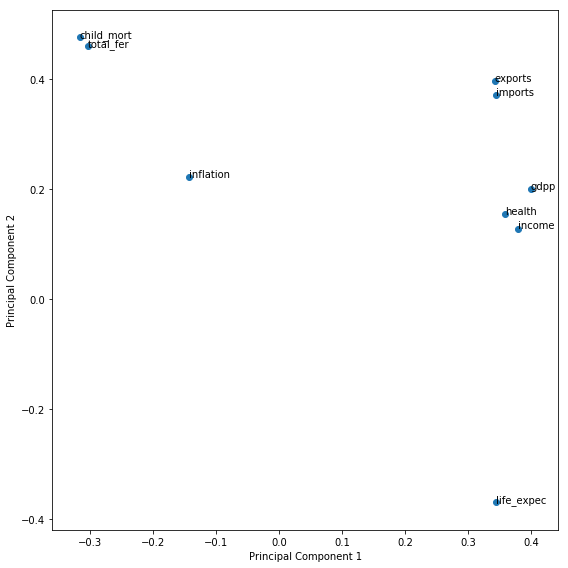

In [128]:
#Let's visualise the first 2 components
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

A lot of variables have a good loading score on the first principal component. Similarly Child mortality and total fertility is well explained by the 2nd prinicpal component.

In [129]:
#We are observing 90% variance with 3 principal components. So let's take the data until that many components
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=3)

In [130]:
#let's project our original data on the 3 principal components
df_train_pca = pca_final.fit_transform(dat2)
df_train_pca.shape

(167, 3)

In [131]:
#take the transpose of the PC matrix so that we can create the new matrix
pc = np.transpose(df_train_pca)
pc

array([[-2.63744157e+00, -2.22769569e-02, -4.57626261e-01,
        -2.72452030e+00,  6.49848516e-01,  3.71968554e-02,
        -3.32691520e-01,  3.18036154e+00,  3.81568156e+00,
        -4.67515152e-01,  1.49875246e+00,  1.47097104e+00,
        -1.01419903e+00,  8.45238116e-01, -1.34473920e-02,
         3.96087770e+00, -4.02707071e-01, -2.36598657e+00,
        -7.14998191e-01, -1.01778054e+00,  2.52812687e-01,
        -1.13095912e+00,  1.66280202e-01,  2.69525065e+00,
         2.80569006e-01, -2.75387449e+00, -2.76406823e+00,
        -1.17929406e+00, -2.44142939e+00,  3.39411994e+00,
        -5.23229456e-01, -3.24153046e+00, -3.18889212e+00,
         6.92394286e-01, -1.28851026e-01, -1.38822916e-02,
        -1.94991207e+00, -3.11679859e+00, -2.04776384e+00,
         4.31523541e-01, -2.57476033e+00,  8.46278142e-01,
         2.31379384e+00,  1.67463303e+00,  4.37600084e+00,
        -3.67788028e-01, -3.02658561e-01, -8.36646810e-01,
        -3.36572123e-01, -1.05577406e+00, -1.94848965e+0

In [132]:
#Let's create the newer matrix according to the given principal components
rownames = list(dat['country'])
pcs_df2 = pd.DataFrame({'country':rownames,'PC1':pc[0],'PC2':pc[1],'PC3':pc[2]})
pcs_df2.head()

,country,PC1,PC2,PC3
0,Afghanistan,-2.637442,1.469038,-0.541359
1,Albania,-0.022277,-1.431896,-0.020701
2,Algeria,-0.457626,-0.673301,0.961867
3,Angola,-2.724520,2.174583,0.606687
4,Antigua and Barbuda,0.649849,-1.024374,-0.250103


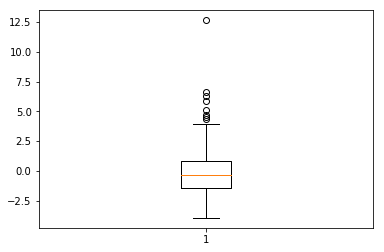

In [133]:
#Let's do the outlier analysis before proceeding to clustering
#We can reassign the outliers to the clusters later
plt.boxplot(pcs_df2.PC1)
Q1 = pcs_df2.PC1.quantile(0.05)
Q3 = pcs_df2.PC1.quantile(0.95)
IQR = Q3 - Q1
pcs_df2 = pcs_df2[(pcs_df2.PC1 >= Q1) & (pcs_df2.PC1 <= Q3)]

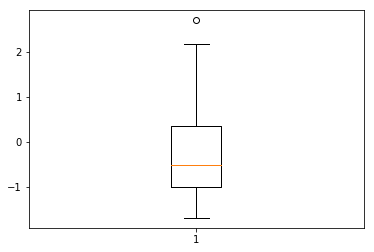

In [134]:
plt.boxplot(pcs_df2.PC2)
Q1 = pcs_df2.PC2.quantile(0.05)
Q3 = pcs_df2.PC2.quantile(0.95)
IQR = Q3 - Q1
pcs_df2 = pcs_df2[(pcs_df2.PC2 >= Q1) & (pcs_df2.PC2 <= Q3)]

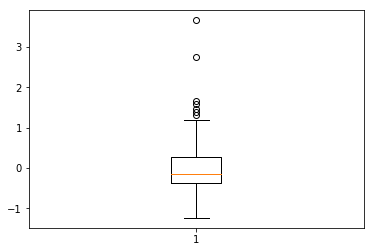

In [135]:
plt.boxplot(pcs_df2.PC3)
Q1 = pcs_df2.PC3.quantile(0.05)
Q3 = pcs_df2.PC3.quantile(0.95)
IQR = Q3 - Q1
dat3 = pcs_df2[(pcs_df2.PC3 >= Q1 ) & (pcs_df2.PC3 <= Q3)]

In [136]:
#Outlier analysis is now done.Let's check the data again.
pcs_df2.shape

(133, 4)

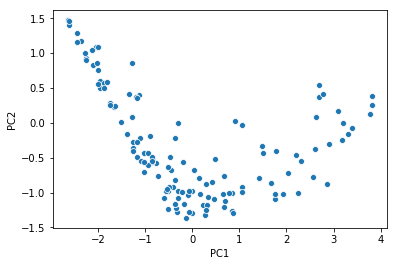

In [137]:
#let's check the spread of the dataset
sns.scatterplot(x='PC1',y='PC2',data=pcs_df2)

## Clustering

As we checked previously the dataset looks of similar magnitude. Hence no further standardisation is necessary.
Let's proceed to calculating the Hopkins statistic to ensure that the data is good for clustering.


In [138]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [139]:
#Let's check the Hopkins measure
hopkins(pcs_df2.drop(['country'],axis=1))

0.8286149182127605

In [140]:
#0.83 is a good Hopkins score. Hence the data is suitable for clustering. Preliminary check is now done.
#We can do standardisation again or else we can skip this step as well.
dat3 = pcs_df2
dat3_1 = standard_scaler.fit_transform(dat3.drop(['country'],axis=1))

### K-means Clustering

In [141]:
#Let's check the silhouette score first to identify the ideal number of clusters
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(dat3_1)
    sse_.append([k, silhouette_score(dat3_1, kmeans.labels_)])

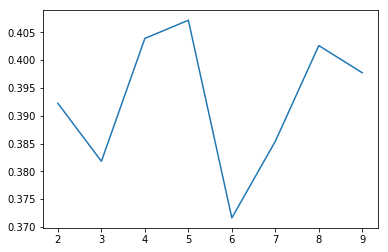

In [142]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

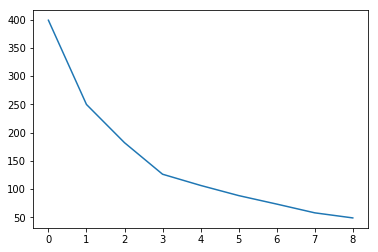

In [143]:
#The sihouette score reaches a peak at around 5 clusters indicating that it might be the ideal number of clusters.
#Let's use the elbow curve method to identify the ideal number of clusters.
ssd = []
for num_clusters in list(range(1,10)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(dat3_1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [144]:
#A distinct elbow is formed at around 3-7 clusters. Let's finally create the clusters and see for ourselves which ones fare better
#K-means with k=5 clusters
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(dat3_1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [145]:
dat4=dat3
dat4.index = pd.RangeIndex(len(dat4.index))
dat_km = pd.concat([dat4, pd.Series(model_clus5.labels_)], axis=1)
dat_km.columns = ['country', 'PC1', 'PC2','PC3','ClusterID']
dat_km.head()

,country,PC1,PC2,PC3,ClusterID
0,Afghanistan,-2.637442,1.469038,-0.541359,4
1,Algeria,-0.457626,-0.673301,0.961867,3
2,Antigua and Barbuda,0.649849,-1.024374,-0.250103,1
3,Argentina,0.037197,-0.680889,1.466963,3
4,Armenia,-0.332692,-1.274517,0.176636,1


In [146]:
dat_km['ClusterID'].value_counts()

1    59
4    26
0    26
3    14
2     8
Name: ClusterID, dtype: int64

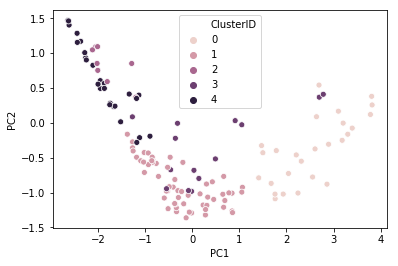

In [147]:
#Each cluster has a good number of countries associated with it(at least 5% of the dataset under consideration)
#Let's do some further visualizations.
#We'll be visualising the clusters on the original principal components
sns.scatterplot(x='PC1',y='PC2',hue='ClusterID',legend='full',data=dat_km)

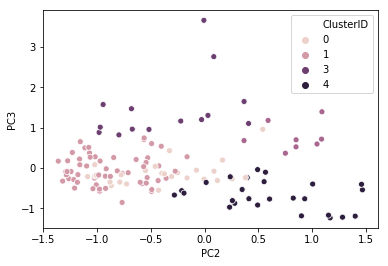

In [148]:
sns.scatterplot(x='PC2',y='PC3',hue='ClusterID',data=dat_km)

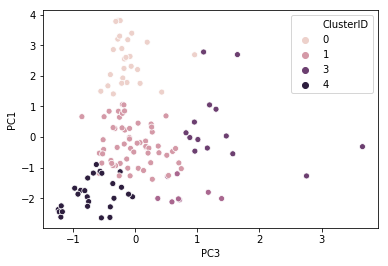

In [149]:
sns.scatterplot(x='PC3',y='PC1',hue='ClusterID',data=dat_km)

In [150]:
#One thing we noticed is some even though some distinct clusters are being formed, some are not so good.
#Now let's create the cluster means wrt to the various variables mentioned in the question and plot and see how they are related
dat5=pd.merge(dat,dat_km,on='country')
dat6=dat5[['country','child_mort','exports','imports','health','income','inflation','life_expec','total_fer','gdpp','ClusterID']]
clu_chi = 	pd.DataFrame(dat6.groupby(["ClusterID"]).child_mort.mean())
clu_exp= 	pd.DataFrame(dat6.groupby(["ClusterID"]).exports.mean())
clu_imp = 	pd.DataFrame(dat6.groupby(["ClusterID"]).imports.mean())
clu_hea = 	pd.DataFrame(dat6.groupby(["ClusterID"]).health.mean())
clu_inc = 	pd.DataFrame(dat6.groupby(["ClusterID"]).income.mean())
clu_inf = 	pd.DataFrame(dat6.groupby(["ClusterID"]).inflation.mean())         
clu_lif = 	pd.DataFrame(dat6.groupby(["ClusterID"]).life_expec.mean())
clu_tot = 	pd.DataFrame(dat6.groupby(["ClusterID"]).total_fer.mean())
clu_gdpp = 	pd.DataFrame(dat6.groupby(["ClusterID"]).gdpp.mean())

df = pd.concat([pd.Series([0,1,2,3,4]),clu_chi,clu_exp,clu_imp,clu_hea,clu_inc,clu_inf,clu_lif,clu_tot,clu_gdpp], axis=1)
df.columns = ["ClusterID", "Child_Mortality", "Exports", "Imports","Health_Spending","Income","Inflation","Life_Expectancy","Total_Fertility","GDPpcapita"]
df

,ClusterID,Child_Mortality,Exports,Imports,Health_Spending,Income,Inflation,Life_Expectancy,Total_Fertility,GDPpcapita
ClusterID,,,,,,,,,,
0,0.0,5.111538,14074.200000,13725.319231,3335.156154,35707.692308,1.858577,79.838462,1.731538,34550.000000
1,1.0,23.535593,2612.041839,2876.256629,376.153092,10690.508475,5.770017,72.737288,2.322034,5781.050847
2,2.0,66.525000,1364.012500,966.090000,170.390000,6171.250000,19.887500,65.725000,4.827500,3111.250000
3,3.0,15.557143,7198.816429,4200.612143,528.118714,29805.000000,20.321429,73.814286,2.307857,13610.714286
4,NaN,72.657692,639.146415,857.742692,126.934292,3425.000000,5.267500,60.619231,4.371538,1740.615385


We observe that Child mortality, Income, Inflation and GDP per capita are good predictors for the development of a country. On cross-checking with the original Principal components that we drew, these 4 components had good scores. Hence we can say that they are a good source of information for the Clustering Process.Let's visualise the clusters along these.

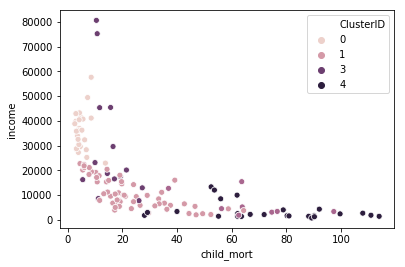

In [151]:
#Along child-mortality and income
sns.scatterplot(x='child_mort',y='income',hue='ClusterID',data=dat6)

In [152]:
#let's take a look at those countries clusters and try to make sense if the clustering process worked well.
dat6[dat6['ClusterID']==0]

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,ClusterID
5,Australia,4.8,10276.2,10847.1,4530.87,41400,1.160,82.0,1.93,51900,0
6,Austria,4.3,24059.7,22418.2,5159.00,43200,0.873,80.5,1.44,46900,0
8,Bahamas,13.8,9800.0,12236.0,2209.20,22900,-0.393,73.8,1.86,28000,0
9,Bahrain,8.6,14386.5,10536.3,1028.79,41100,7.440,76.0,2.16,20700,0
23,Canada,5.6,13793.4,14694.0,5356.20,40700,2.870,81.3,1.63,47400,0
31,Cyprus,3.6,15461.6,17710.0,1838.76,33900,2.010,79.9,1.42,30800,0
32,Czech Republic,3.4,13068.0,12454.2,1560.24,28300,-1.430,77.5,1.51,19800,0
40,Finland,3.0,17879.4,17278.8,4134.90,39800,0.351,80.0,1.87,46200,0
41,France,4.2,10880.8,11408.6,4831.40,36900,1.050,81.4,2.03,40600,0
45,Germany,4.2,17681.4,15507.8,4848.80,40400,0.758,80.1,1.39,41800,0


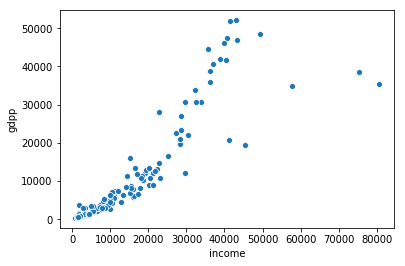

In [154]:
#K-means has done a satisfactory job here. Let's take a different approach and make the clusters only on the basis of these
sns.scatterplot(x='income',y='gdpp',data=dat6)

###  From the clusters it is observed that cluster 2 and 4 have pretty low values of the 4 indicators that we chose. Hence these are the countries that we need to focus.

## Hierarchical Clustering
Let's check if hierarchical clustering does a good job.

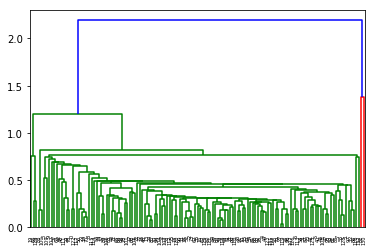

In [155]:
#Let's try hierarchical clustering to see if it works well
#First we'll try the single linkage procedure.
mergings = linkage(dat3_1, method = "single", metric='euclidean')
dendrogram(mergings)
plt.show()

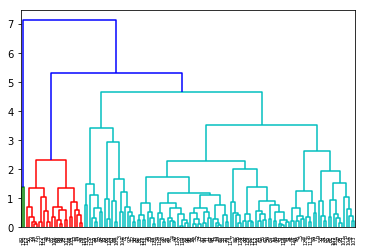

In [156]:
#We don't get good results here.
#Let's try complete linkage method
mergings = linkage(dat3_1, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [157]:
#Okay now we are seeing some good clusters here. Let's see if they make sense if we eliminate the barriers
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 5).reshape(-1,))
dat3_hc = pd.concat([dat3, clusterCut], axis=1)
dat3_hc.columns = ['country', 'PC1', 'PC2','PC3','ClusterID']

In [158]:
dat3_hc.head()

,country,PC1,PC2,PC3,ClusterID
0,Afghanistan,-2.637442,1.469038,-0.541359,0
1,Algeria,-0.457626,-0.673301,0.961867,1
2,Antigua and Barbuda,0.649849,-1.024374,-0.250103,2
3,Argentina,0.037197,-0.680889,1.466963,1
4,Armenia,-0.332692,-1.274517,0.176636,2


In [159]:
dat7=pd.merge(dat,dat3_hc,on='country')
dat8=dat7[['country','child_mort','exports','imports','health','income','inflation','life_expec','total_fer','gdpp','ClusterID']]
dat8.head()

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Afghanistan,90.2,55.30,248.297,41.9174,1610,9.44,56.2,5.82,553,0
1,Algeria,27.3,1712.64,1400.440,185.9820,12900,16.10,76.5,2.89,4460,1
2,Antigua and Barbuda,10.3,5551.00,7185.800,735.6600,19100,1.44,76.8,2.13,12200,2
3,Argentina,14.5,1946.70,1648.000,834.3000,18700,20.90,75.8,2.37,10300,1
4,Armenia,18.1,669.76,1458.660,141.6800,6700,7.77,73.3,1.69,3220,2


In [160]:
dat8['ClusterID'].value_counts()

2    61
3    26
0    23
1    21
4     2
Name: ClusterID, dtype: int64

In [63]:
#Cluster 4 doesn't have enough amount of clusters. Let's see if other clusters are good or not.
dat8[dat8['ClusterID']==2]

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,ClusterID
4,Australia,4.8,10276.2,10847.1,8.73,41400,1.160,82.0,1.93,51900,2
5,Austria,4.3,24059.7,22418.2,11.00,43200,0.873,80.5,1.44,46900,2
7,Bahamas,13.8,9800.0,12236.0,7.89,22900,-0.393,73.8,1.86,28000,2
23,Canada,5.6,13793.4,14694.0,11.30,40700,2.870,81.3,1.63,47400,2
32,Czech Republic,3.4,13068.0,12454.2,7.88,28300,-1.430,77.5,1.51,19800,2
40,Finland,3.0,17879.4,17278.8,8.95,39800,0.351,80.0,1.87,46200,2
41,France,4.2,10880.8,11408.6,11.90,36900,1.050,81.4,2.03,40600,2
45,Germany,4.2,17681.4,15507.8,11.60,40400,0.758,80.1,1.39,41800,2
47,Greece,3.9,5944.9,8258.3,10.30,28700,0.673,80.4,1.48,26900,2
53,Iceland,2.6,22374.6,18142.7,9.40,38800,5.470,82.0,2.20,41900,2


In [65]:
dat8[dat8['ClusterID']==3]
#this would be the cluster that we need to focus on

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,ClusterID
13,Benin,111.0,180.4040,281.976,4.10,1820,0.885,61.8,5.36,758,3
22,Cameroon,108.0,290.8200,353.700,5.13,2660,1.910,57.3,5.11,1310,3
29,"Congo, Rep.",63.9,2331.7400,1498.780,2.46,5190,20.700,60.4,4.95,2740,3
37,Eritrea,55.2,23.0878,112.306,2.66,1420,11.600,61.7,4.61,482,3
42,Gabon,63.7,5048.7500,1653.750,3.50,15400,16.600,62.9,4.08,8750,3
43,Gambia,80.3,133.7560,239.974,5.69,1660,4.300,65.5,5.71,562,3
46,Ghana,74.7,386.4500,601.290,5.22,3060,16.600,62.2,4.27,1310,3
68,Lao,78.9,403.5600,562.020,4.47,3980,9.200,63.8,3.15,1140,3
74,Madagascar,62.2,103.2500,177.590,3.77,1390,8.790,60.8,4.60,413,3
78,Mauritania,97.4,608.4000,734.400,4.41,3320,18.900,68.2,4.98,1200,3


In [67]:
dat8[dat8['ClusterID']==0]
#some countries haven't been properly clustered here.

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Algeria,27.3,1712.64000,1400.440000,4.17,12900,16.10,76.5,2.89,4460,0
6,Azerbaijan,39.2,3171.12000,1208.880000,5.88,16000,13.80,69.1,1.92,5840,0
9,Bangladesh,49.4,121.28000,165.244000,3.52,2440,7.14,70.4,2.33,758,0
15,Bolivia,46.6,815.76000,679.140000,4.84,5410,8.78,71.6,3.20,1980,0
18,Brunei,10.5,23792.20000,9884.000000,2.84,80600,16.70,77.1,1.84,35300,0
35,Egypt,29.1,553.80000,691.600000,4.66,9860,10.10,70.5,3.19,2600,0
54,India,58.8,305.10000,365.850000,4.05,4410,8.98,66.2,2.60,1350,0
55,Indonesia,33.3,755.73000,696.640000,2.61,8430,15.30,69.9,2.48,3110,0
63,Kazakhstan,21.5,4008.94000,2711.930000,4.29,20100,19.50,68.4,2.60,9070,0
66,Kuwait,10.8,25679.50000,11704.000000,2.63,75200,11.20,78.2,2.21,38500,0


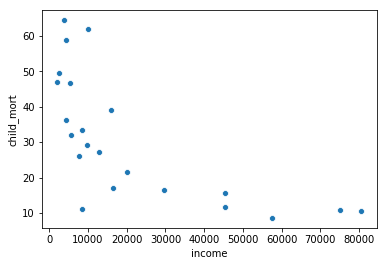

In [68]:
#Let's visualise the clusters here. We don't see the countries properly clustered here. Hence we don't create cluster means
#as that would give a skewed result
datp=dat8[dat8['ClusterID']==0]
sns.scatterplot(x='income',y='child_mort',data=datp)

#### Final result : We use the clusters formed during K-means clustering to find the countries that we require since Hierarchical clustering is not showing proper clusters here. For K-means part, we got Cluster 2 and 4 might be the ones which has a proper need of aid.

### Note 1

In this solution K-means and Hierarchical don't produce identical insights.This would depend on the way the principal components and the final number of clusters are chosen. It would be perfectly fine if both provide identical insights in any other case

###  Note 2
For outliers that we removed before clustering took place, you can take any approach to include them in the final list of countries that you'd focus on. Either reassign them to the clusters that were formed and see if Cluster 2 and Cluster 4 have any more countries. Or use one variable from some of the main indicators to bin the entire 167 countries. Like if you take GDPP, keep the bin limits as 0-1700, 1700-3200,3200-6000,6000-13000 and >13000. The bin limits are decided on the basis of the approximate gdpp means that we got for the 5 clusters. Categorise all the countries from the original dataset within these limits and then take all the countries less than 1700 as the cutoff.Similarly, proceed for the 2nd variable.Any other logically thought out approach also works.